In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

For our model, it's worth considering which countries in our dataset we consider as priveleged or unpriveleged. To this end, we will investigate which countries are overrepresented and underrepresented within our dataset.

In [2]:
user_df = pd.read_csv('../data/filtered_user_df.csv')
with open('../data/artist_location_codes.json', 'r') as file:
    # TODO: Why is Drake Polish?
    # Also, The Beatles are missing
    artist_locations = json.load(file)

In [3]:
play_count_df = user_df[['artist_name', 'play_count']]
play_count_df['country'] = play_count_df['artist_name'].map(artist_locations)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2395307624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_count_df['country'] = play_count_df['artist_name'].map(artist_locations)


In [4]:
country_play_counts = play_count_df.groupby('country').sum().sort_values(by='play_count')

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\626412569.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_play_counts = play_count_df.groupby('country').sum().sort_values(by='play_count')


In [30]:
# artist_locations

Plotting countries by total play count, we notice that our distribution is so skewed in favor of the top countries that the plot still appears exponential even when scaled logarithmically.

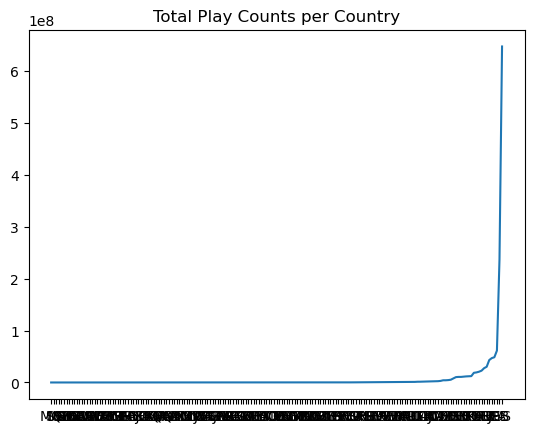

In [6]:
plt.title('Total Play Counts per Country')
plt.plot(country_play_counts['play_count'], scaley='log')

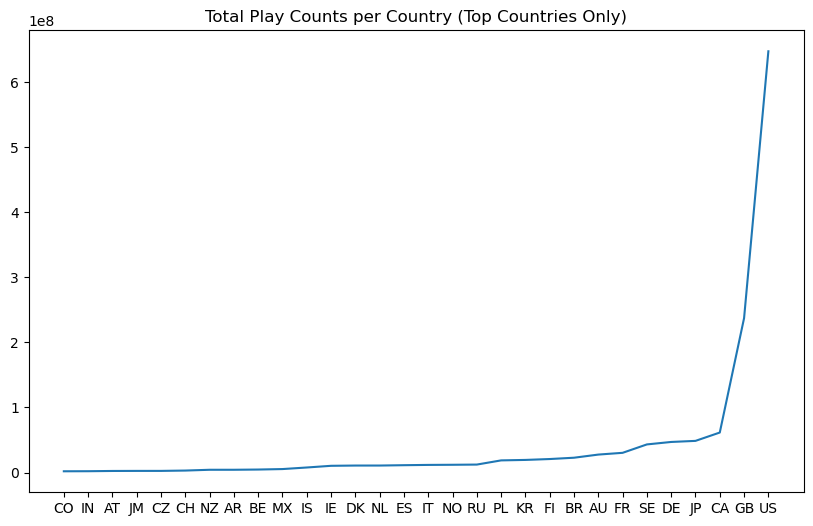

In [7]:
plt.figure(figsize=(10,6))
plt.title('Total Play Counts per Country (Top Countries Only)')
plt.plot(country_play_counts['play_count'].tail(30), scaley='log')

Something worth noting about our dataset is the high play counts of Scandinavian countries like Sweden, Norway, and Finland. These countries are primarily musically notable for their proliferation of metal bands. As metal is a relatively niche genre, the high placements for these countries could be caused by overrepresentations of metal listeners in our dataset. This may merit further investigation down the line. If metal bias is the cause, then it may be worth marking them as unpriveleged despite their high leads, as artists working in other genres besides metal in those countries could still be underrepresented in recommendations, and given the relative lack of popularity of metal, an overrepresentation of Scandinavian representation in specifically metal may not significantly affect the model's output.

In [8]:
country_counts = play_count_df.groupby('country').count().sort_values(by='play_count')

We notice a similar skew when plotting by the representation of artists per country in users' top 50 artists.

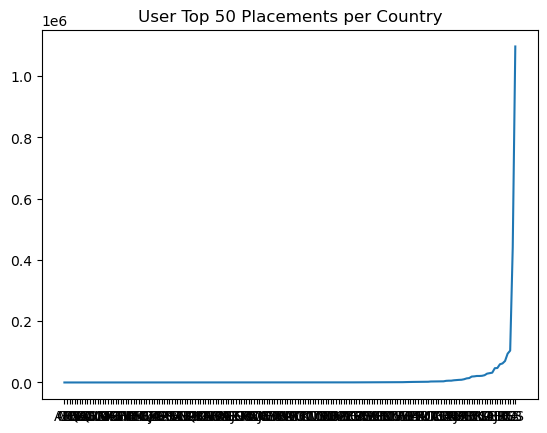

In [9]:
plt.title('User Top 50 Placements per Country')
plt.plot(country_counts['play_count'], scaley='log')

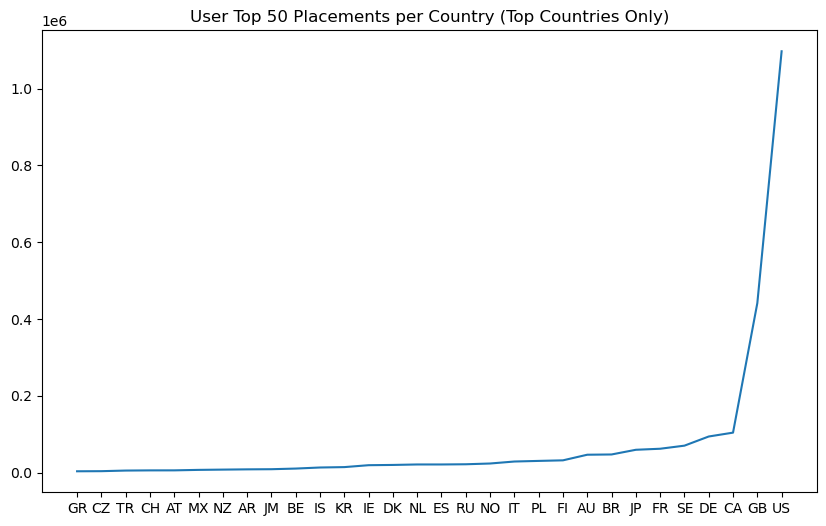

In [10]:
plt.figure(figsize=(10,6))
plt.title('User Top 50 Placements per Country (Top Countries Only)')
plt.plot(country_counts['play_count'].tail(30), scaley='log')

When plotting how many times more plays each country has than the previous highest, we notice that there are a few countries in the lead that have dramatically more plays than those behind them before the ratios begin to level out.

In [11]:
country_play_counts_offset = np.concatenate((np.array([1]), country_play_counts['play_count'][:-1].array))
prev_plays_ratios = country_play_counts['play_count'] / country_play_counts_offset

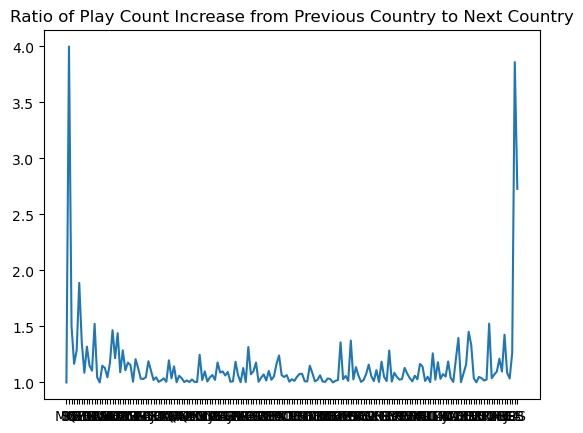

In [12]:
plt.title('Ratio of Play Count Increase from Previous Country to Next Country')
plt.plot(prev_plays_ratios)

To get a better understanding of where the ratios level out, we will plot just the top countries to find the cusp.

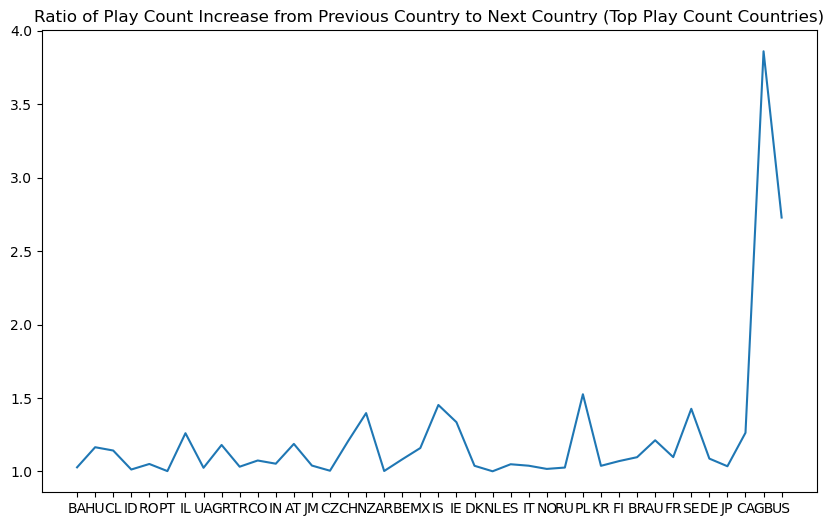

In [13]:
plt.figure(figsize=(10,6))
plt.title('Ratio of Play Count Increase from Previous Country to Next Country (Top Play Count Countries)')
plt.plot(prev_plays_ratios.tail(40))

It appears as if the last major spike in ratios is from Mexico to Iceland. As such, for this portion of our analysis, we will consider the subset of top countries from Iceland to the United States.

It is worth investigating whether the top countries are at the top because of general popularity or if a few extremely popular artists are skewing them high. To do so, we will plot the play counts of the top *k* artists of each country versus the average play counts of the countries.

In [14]:
top_plays_countries = prev_plays_ratios.tail(20).index

In [15]:
artist_summed_plays = play_count_df.groupby(['country', 'artist_name']).sum().reset_index()
country_mean_plays =  artist_summed_plays.groupby('country').mean()

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3287840095.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()


In [16]:
country_mean_plays.loc[top_plays_countries]

,play_count
country,
IS,56053.108696
IE,28225.439891
DK,18216.529711
NL,7512.701399
ES,8149.597252
IT,5806.948934
NO,13888.533800
RU,8807.244060
PL,14753.926482


In [17]:
def plot_top_k_ratios(k, play_count_df, top_plays_countries):
    artist_summed_plays = play_count_df.groupby(['country', 'artist_name']).sum().reset_index()
    country_mean_plays =  artist_summed_plays.groupby('country').mean()
    country_counts_sorted = play_count_df.sort_values(by=['country', 'play_count'], ascending=[True, False])
    artist_plays_sorted = artist_summed_plays.sort_values(['country', 'play_count'], ascending=[True, False])
    top_k_per_country = artist_plays_sorted.groupby('country').head(k)
    mean_top_k_per_country = top_k_per_country.groupby('country').mean()
    top_to_avg_ratio = mean_top_k_per_country.loc[top_plays_countries].get('play_count') / country_mean_plays.loc[top_plays_countries].get('play_count')
    
    plt.title(f'Ratio of country\'s top {k} artists\' play counts to its average artist play counts')
    plt.plot(top_to_avg_ratio)

In the plots below, we can see that the U.S., France, and Japan demonstrate by far the most distance between play counts of top artists and average play counts.

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


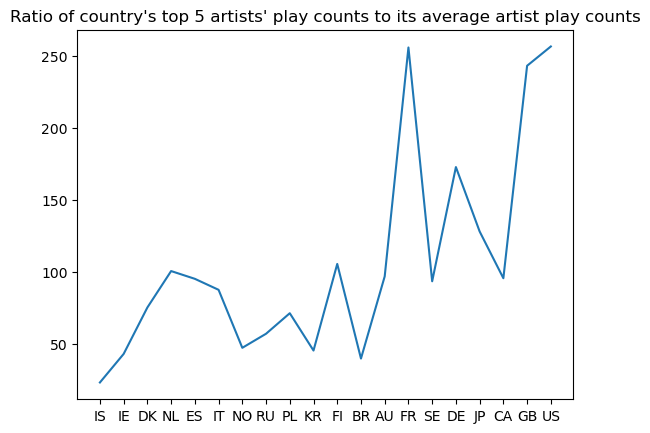

In [18]:
plot_top_k_ratios(5, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


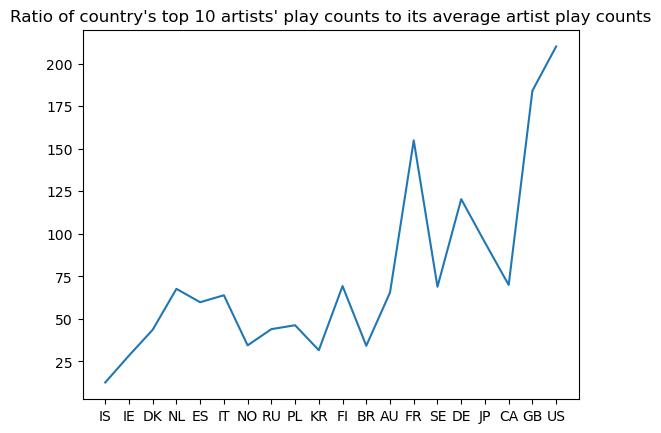

In [19]:
plot_top_k_ratios(10, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


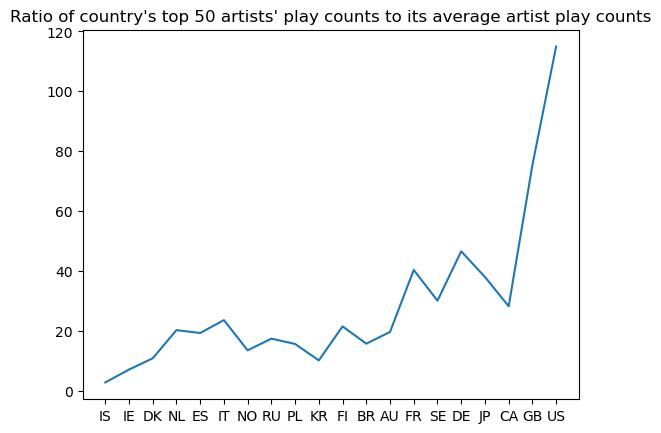

In [20]:
plot_top_k_ratios(50, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


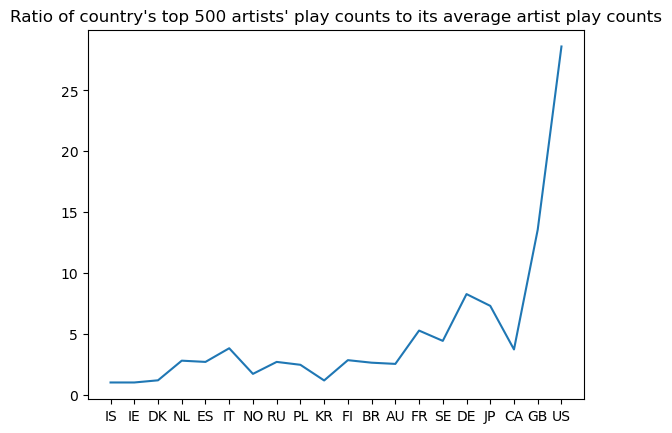

In [21]:
plot_top_k_ratios(500, play_count_df, top_plays_countries)

When interpreting these plots, it's important to consider the amount of artists in each country, as the US has more artists than, say, Iceland. As such, the top 500 artists in Iceland are going to be far more representative of the mean artists for that country than the top 500 in the US.

In [22]:
user_df

,Unnamed: 0.1,Unnamed: 0,user,artist_name,play_count,artist_url
0,0,0,nyancrimew,Jasmine Thompson,7559.0,https://www.last.fm/music/Jasmine+Thompson
1,1,1,nyancrimew,Eminem,5851.0,https://www.last.fm/music/Eminem
2,2,2,nyancrimew,Watsky,3044.0,https://www.last.fm/music/Watsky
3,3,3,nyancrimew,Linkin Park,2938.0,https://www.last.fm/music/Linkin+Park
4,7,7,nyancrimew,twenty one pilots,1849.0,https://www.last.fm/music/twenty+one+pilots
...,...,...,...,...,...,...
2387965,2938626,2938626,sgcravas,Rage Against the Machine,368.0,https://www.last.fm/music/Rage+Against+the+Mac...
2387966,2938627,2938627,sgcravas,Pixies,359.0,https://www.last.fm/music/Pixies
2387967,2938628,2938628,sgcravas,Alice in Chains,352.0,https://www.last.fm/music/Alice+in+Chains
2387968,2938629,2938629,sgcravas,AC/DC,349.0,https://www.last.fm/music/AC%2FDC


Now we will investigate how genre bias affects the placements of our top countries. We will begin by inspecting the Scandinavian countries on our list.

In [31]:
top_plays_countries

Index(['IS', 'IE', 'DK', 'NL', 'ES', 'IT', 'NO', 'RU', 'PL', 'KR', 'FI', 'BR',
       'AU', 'FR', 'SE', 'DE', 'JP', 'CA', 'GB', 'US'],
      dtype='object', name='country')

In [78]:
def get_country_top_artists(country):
    specific_country_df = play_count_df[play_count_df['country'] == country]
    artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False)
    return artist_play_counts

In [43]:
finland_play_counts = get_country_top_artists('FI')
finland_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Nightwish,3061359.0
Sonata Arctica,1574644.0
Children of Bodom,1305877.0
Apocalyptica,831167.0
Amorphis,788177.0
Ensiferum,620808.0
Stratovarius,525231.0
Poets of the Fall,407288.0
Finntroll,402770.0


These results bode well for our assumption. Nine of the ten bands here are metal bands. We will also examine the other Scandinavian countries.

In [44]:
sweden_play_counts = get_country_top_artists('SE')
sweden_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
In Flames,2880689.0
Opeth,2070652.0
Katatonia,1716884.0
Amon Amarth,1046553.0
Sabaton,1038358.0
Tove Lo,901067.0
Lykke Li,867546.0
Bladee,820940.0
Arch Enemy,810420.0


Sweden features six metal artists in its top ten most popular artists, demonstrating strong metal bias, especially considering all of these artists have more plays than ABBA, arguably the most popular musical act in Sweden's history. The average person is surely more familiar with ABBA than Katatonia.

In [45]:
denmark_play_counts = get_country_top_artists('DE')
denmark_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Rammstein,3917907.0
Blind Guardian,1402489.0
Beirut,1389667.0
Helloween,987753.0
Johann Sebastian Bach,959356.0
Scorpions,799490.0
Death,763375.0
Kreator,619664.0
IAMX,617524.0


Here we see seven metal bands in Denmark's top 10. There are two notable mistaggings here; both Death and Beirut are American bands.

In [46]:
norway_play_counts = get_country_top_artists('NO')
norway_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Röyksopp,1136136.0
Ulver,655124.0
Dimmu Borgir,637424.0
Burzum,471772.0
Girl Talk,401322.0
Darkthrone,339068.0
a-ha,323038.0
Theatre of Tragedy,285479.0
Immortal,272405.0


Once again, six metal bands in the top 10. This is an indication that the high placements for these countries may rely on a bias towards metal among Last.fm users rather than great musical popularity of their acts as a whole. As Scandinavian countries are known for their metal bands, this makes sense, but we will explore the other unusual placements in the top 20 to see if there's an explanation for them being there besides popularity.

In [79]:
iceland_play_counts = get_country_top_artists('IS')
iceland_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\2163754735.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False)


,play_count
artist_name,
Björk,2947493.0
Sigur Rós,2532870.0
Ólafur Arnalds,507393.0
Of Monsters and Men,310317.0
múm,284636.0
Jóhann Jóhannsson,132986.0
GusGus,94981.0
Sólstafir,90576.0
Emilíana Torrini,88613.0


Iceland exhibits an unusual phenomenon: it features two incredibly popular artists, Bjork and Sigur Ros, but no one else in the country even approaches their popularity within our dataset. 

In [52]:
iceland_play_counts.loc[['Sigur Rós', 'Björk'], 'play_count'].sum() / iceland_play_counts['play_count'].sum()

0.77525304393979

<BarContainer object of 40 artists>

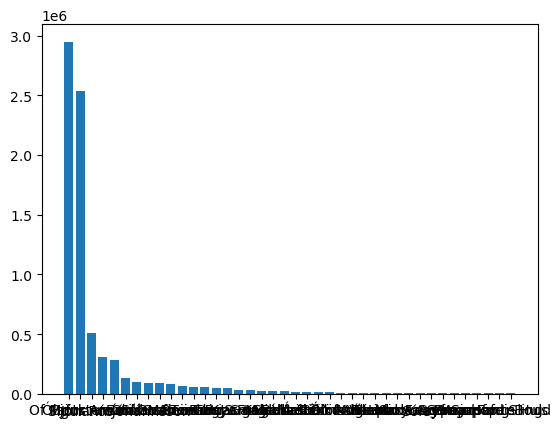

In [81]:
plt.bar(iceland_play_counts.head(40).index, iceland_play_counts.head(40)['play_count'])

These two artists are so popular that 77% of all plays of Icelandic music in our dataset are exclusively for their music. As such, it would be unreasonable to file Iceland as a priveleged country considering how far Bjork and Sigur Ros are inflating its placement.

In [59]:
japan_play_counts = get_country_top_artists('JP')
japan_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Queen,3182981.0
HIM,1281587.0
DIR EN GREY,962567.0
浜崎あゆみ,855011.0
Akira Yamaoka,777237.0
植松伸夫,767796.0
GACKT,758684.0
Prince,721123.0
Machine Head,581199.0


Japan features a surprising amount of miscategorizations among its top artists. None among Queen, HIM, Prince, or Machine Head are actually Japanese artists, and the presence of these four are absolutely affecting Japan's placement.

In [60]:
japan_play_counts.loc[['Queen', 'HIM', 'Prince', 'Machine Head'], 'play_count'].sum() / japan_play_counts['play_count'].sum()

0.5521979179433754

Combined, these four mistagged artists make up over half of Japan's plays. In addition, this list reflects the same metal bias seen previously, given how this list features DIR EN GREY as the most popular correctly tagged Japanese artist.

In contrast, let us examine the three unambiguously most played countries.

In [71]:
us_play_counts = get_country_top_artists('US')
us_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Taylor Swift,10684811.0
Lady Gaga,9649626.0
Lana Del Rey,7884328.0
Britney Spears,7621370.0
Metallica,6304683.0
Linkin Park,5592924.0
Red Hot Chili Peppers,5382279.0
Madonna,5368345.0
Kanye West,5278521.0


In [72]:
uk_play_counts = get_country_top_artists('GB')
uk_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Radiohead,13343947.0
Arctic Monkeys,8200830.0
Coldplay,6645356.0
Rihanna,5149459.0
Iron Maiden,4462001.0
The Smiths,4392086.0
Nirvana,4203392.0
Depeche Mode,4031995.0
The Cure,4022550.0


In [73]:
ca_play_counts = get_country_top_artists('CA')
ca_play_counts.head(10)

C:\Users\joshu\AppData\Local\Temp\ipykernel_8804\3439401789.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  artist_play_counts = specific_country_df.groupby('artist_name').sum().sort_values('play_count', ascending=False).head(10)


,play_count
artist_name,
Placebo,4406941.0
Arcade Fire,3386352.0
Avril Lavigne,2988959.0
The Weeknd,2475793.0
Crystal Castles,2316776.0
Grimes,1779391.0
Tegan and Sara,1660966.0
Sum 41,1313499.0
Three Days Grace,1246246.0


Every artist among these countries' top tens is properly tagged, with no notably anomalous placements. Some findings don't align with what would be expected of the general population (e.g. Placebo over The Weeknd), but these findings are not egregious to the point of challenging the integrity of the results. This, along with the facts that these countries drastically surpass all others in plays among our dataset and given how they are the three countries whose music the audience of this study will likely be most familiar with, we will select as our priveleged countries the US, UK, and Canada. (TODO: Beef up this analysis)

(Note: Drake is not present among the Canadian artists here because he was mistagged as Polish)